##**Spam Classification with BERT**

The aim of this project is a spam detection to get a model to predict if the messages is spam or not. This approach we have used a BERT (Bidirectional Encoder Representations from Transformers) model to gain our model. In our analysis we have used a Huggingface Transformers library as well.

**Dataset**

The dataset comes from SMS Spam Collection and that can be found at https://www.kaggle.com/uciml/sms-spam-collection-dataset.

This SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It comprises one set of SMS messages in English of 5,574 messages, which is tagged acording being ham (legitimate) or spam.

**Importing the required libraries**

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model

import transformers
from transformers import BertTokenizer, TFBertModel, TFAutoModel

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**First observations:**

In [3]:
df = pd.read_csv('data/emails.csv', encoding='latin-1')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
df.shape

(5726, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726 entries, 0 to 5725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5726 non-null   object
 1   spam    5726 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB



### **Data preparation**

Remove unnecessary variables:


Rename columns:

In [6]:
df.rename(columns={'spam': 'Class', 'text': 'Text'}, inplace=True)

In [7]:
df.head()

,Text,Class
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


We change column "Class" to 0 and 1:

- spam = 1
- ham = 0



In [8]:
df['Text'][2]

'Subject: unbelievable new homes made easy  im wanting to show you this  homeowner  you have been pre - approved for a $ 454 , 169 home loan at a 3 . 72 fixed rate .  this offer is being extended to you unconditionally and your credit is in no way a factor .  to take advantage of this limited time opportunity  all we ask is that you visit our website and complete  the 1 minute post approval form  look foward to hearing from you ,  dorcas pittman'

In [9]:
# Checking for any missing values
df.isna().sum()

Text     0
Class    0
dtype: int64

### **EDA and Data Visualization**

We check proportion Class variable:

In [10]:
df['Class'].value_counts()

Class
0    4358
1    1368
Name: count, dtype: int64

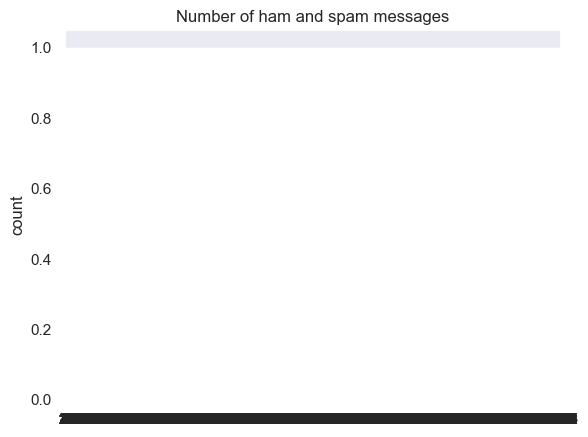

In [11]:
sns.set(style = "darkgrid" , font_scale = 1)
sns.countplot(df.Class).set_title("Number of ham and spam messages")
plt.show()

In [12]:
df.describe()

,Class
count,5726.000000
mean,0.238910
std,0.426455
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


The target class variable is imbalanced, where "ham" values are more dominating than "spam" ones.

**SMS Distribution**

Now we check the percentage of spam SMS and ham SMS messages:

C:\Users\Viper\AppData\Local\Temp\ipykernel_9424\3000149853.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sms = pd.value_counts(df["Class"], sort=True)


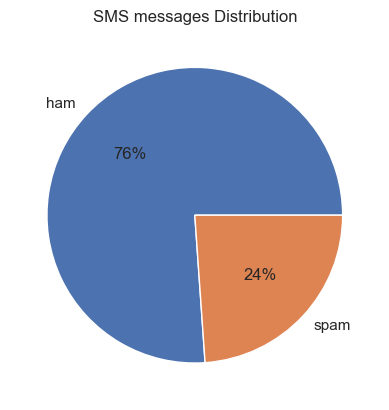

In [13]:
sms = pd.value_counts(df["Class"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

Above 87% of these SMS  messages are ham (legitimate) and 13% of them are spam.


Length of text messages:

In [14]:
df['length'] = df.Text.apply(len)
df.head()

,Text,Class,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


Text(0.5, 0, 'Messages Length')

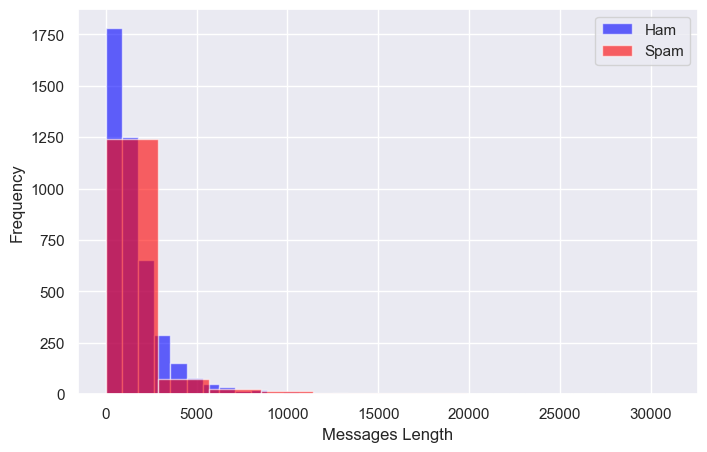

In [15]:
plt.figure(figsize=(8, 5))
df[df.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
df[df.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Messages Length")

Now let's see if the length has an influence on messages spam or ham:

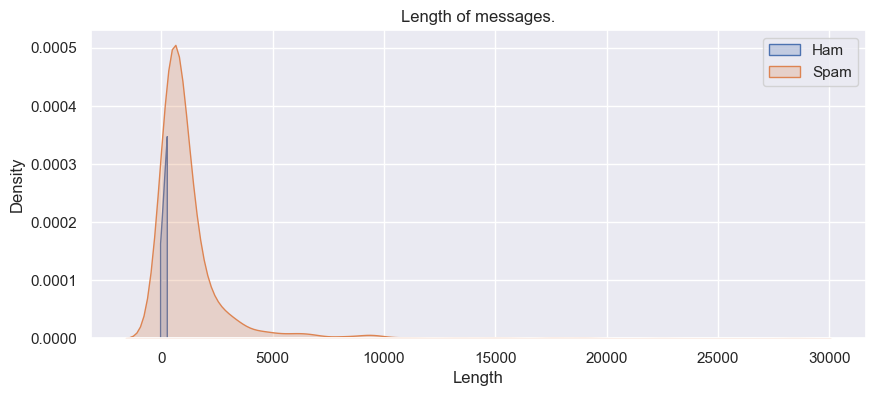

In [16]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.Class == 0, "length"], fill=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.Class == 1, "length"], fill=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()

As we can notice the spam messages are longer than ham ones (that is normal due to the number of words) and  have around 150 characters.

### **Text Pre-processing**

In the next step we clean text, remove stop words and apply stemming operation for each line of text:


In [17]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [18]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [19]:
df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)

In [20]:
df.head()

,Text,Class,length
0,subject natur irresist corpor ident lt realli ...,1,1484
1,subject stock trade gunsling fanni merril muzo...,1,598
2,subject unbeliev new home made easi im want sh...,1,448
3,subject color print special request addit info...,1,500
4,subject money get softwar cd softwar compat gr...,1,235


In [21]:
print(df['Text'].apply(lambda x: len(x.split(' '))).sum())

784308


### **BERT model**

BERT (Bidirectional Encoder Representations from Transformers) is a pretrained NLP algorithm devolped by google AI. BERT is a bidirectionally trained of Transformer a popular attention model, use to language modelling. So it can have a deeper sense of language context and flow compared to the single-direction language models. BERT model instead of predicting the next word in a sequence makes use of a novel technique called Masked LM (MLM). It relies on randomly masks words in the sentence and then it tries to predict them. Unlike the previous language models, it takes both the previous and next tokens into account at the same time. This is a contrast to previous LSTM based models combined a text sequence left-to-right and right-to-left.

In the first step we have to make tokenization on our dataset. Tokenization will allow us to feed batches of sequences into the model at the same time. 

To do the tokenization of our datasets we have to choose  a pre-trained model. We load the basic model (`bert-large-uncased`) from the Huggingface Transformers library.

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
tokenizer

BertTokenizer(name_or_path='bert-large-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Now we have to load BERT model. In the Transformers library is avaliable many different BERT models. We use the „TFBertModel”  model (bert-base-uncased) from the library.

In [58]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# from transformers import AutoModelForSequenceClassification
# bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Spliting the data into train and test sets:

In [59]:
X = df['Text']
y = df['Class']

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

The function which allows to encode our dataset with BERT tokenizer. We have decided on a maximum sentence length is 64 (maxlen).


In [61]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)


Based on this  encodings for our training and testing datasets are generated as follows:

In [62]:
X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=64)
X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=64)

#### **Build the model**

We create a model using BERT model and then add two Dense layers with Dropout layer.

In [63]:
def build_model(bert_model):
   input_word_ids = keras.layers.Input(shape=(64,),dtype='int32')
   attention_masks = keras.layers.Input(shape=(64,),dtype='int32')

   sequence_output = bert_model([input_word_ids,attention_masks])
   output = sequence_output[1]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
   model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

   return model

In [64]:
model = build_model(bert_model)
model.summary()

ValueError: Exception encountered when calling layer 'tf_bert_model_2' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model_2' (type TFBertModel):
  • input_ids=['<KerasTensor shape=(None, 64), dtype=int32, sparse=None, name=keras_tensor_14>', '<KerasTensor shape=(None, 64), dtype=int32, sparse=None, name=keras_tensor_15>']
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

We set class weights for the loss function to adjust for class imbalance. 'Spam' variable is set to weight 8x more.

We train the model for 5 epoch:

In [ ]:
class_weight = {0: 1, 1: 8}

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test),
    class_weight=class_weight)

Visualization of training:

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predictions on a test set:

In [ ]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
print('Test accuracy :', accuracy)

In [ ]:
#save model
model.save_weights('bert_model')

### **Summary**

For our analysis we used a pretrained BERT model to resolve our classification problem.  After trained model we achieved an accuracy on the test set equal to 98 % and it is a very good result in comparison to previous Machine Learning models that we have used (e.g. Logistic Regression).
